In [3]:
# Import relevant packages 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 


/var/folders/mn/8kzb8nld6yz1x00ppzbkn5x40000gn/T/ipykernel_61937/549749232.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data cleaning and exploration 
In the data cleaning and exploration phase, the procedure involves several crucial steps to prepare the dataset for further analysis:

1.	Importing the Data: The first step involves loading the dataset into our working environment. This is typically done using libraries such as Pandas in Python, which allows for reading data from various sources like CSV files, Excel spreadsheets, databases, etc. The goal here is to get the raw data into a format that can be easily manipulated and analyzed.

2.	Examining Summary Statistics and Histograms: Once the data is imported, the next step is to explore it by looking at summary statistics. This includes generating descriptive statistics like mean, median, standard deviation, minimum, and maximum values for numerical data. For categorical data, it might involve looking at the frequency of different categories. These statistics provide an initial understanding of the distribution and central tendencies of the data, helping identify any anomalies, patterns, or trends.
	
3.	Evaluating Null Values: The final step in this initial phase is assessing the presence of null (missing) values in the dataset. Null values can significantly impact the quality of analyses and models. This step involves identifying the columns that contain null values, understanding the proportion of these null values in each column, and deciding on a strategy for handling them. Strategies for dealing with null values include imputation (replacing nulls with substituted values like the mean or median), deletion (removing records with null values), or sometimes leaving them as-is, depending on the context and significance of the missing data.

By methodically performing these steps, you ensure that the dataset is well-understood and primed for more complex analyses or modeling. This phase is crucial as it lays the groundwork for any data-driven insights or conclusions drawn from the subsequent stages of the data analysis process.

In [4]:
# Import data 
training = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

training['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([training,test])

# Function to create a simply styled, scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3 style="color: #333; font-family: Arial, sans-serif;">{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto; border: 1px solid #ccc; border-radius: 4px;">'
    html += df.to_html(border=0)
    html += '</div>'
    return html

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
train_test,891.0,1.000000,0.000000,1.00,1.0000,1.0000,1.0,1.0000


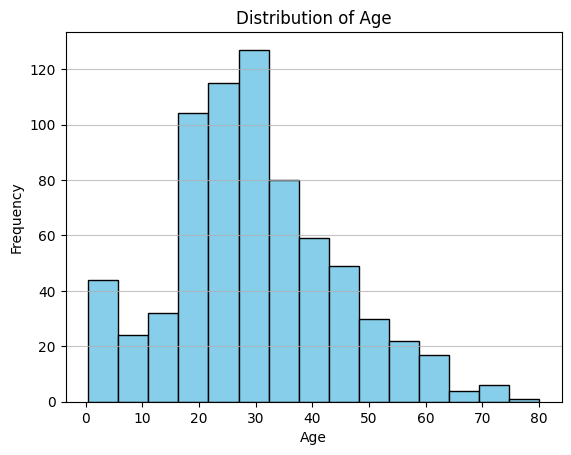

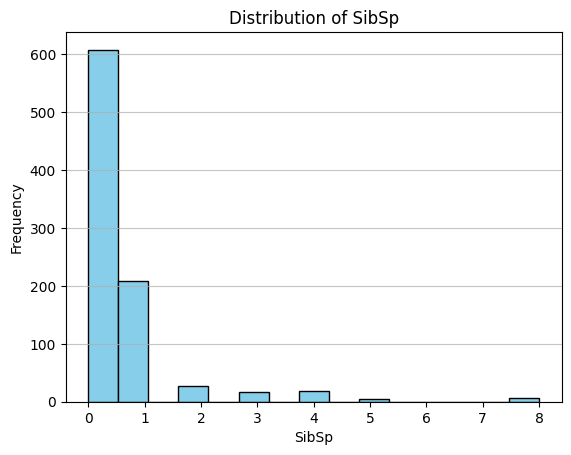

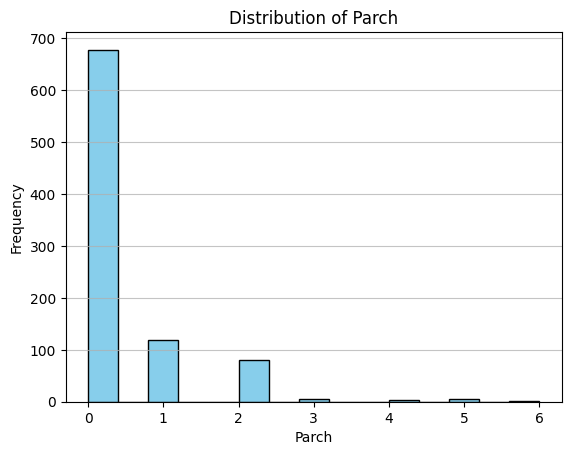

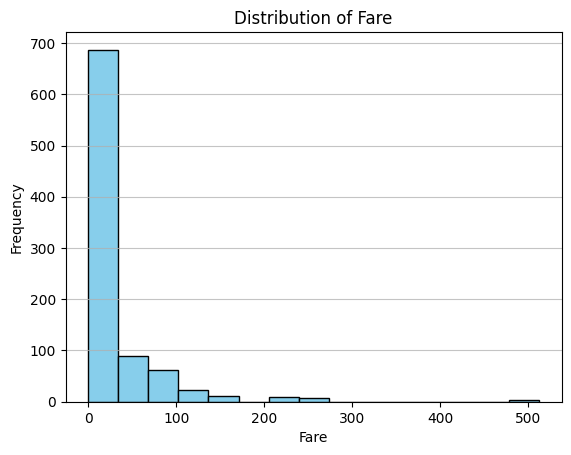

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [5]:
# Summary statistics for numerical features
numerical_feats = training.select_dtypes(include=[np.number])
summary_stats = numerical_feats.describe().T

# Use the previously defined function to create a styled, scrollable table
html_numerical = create_scrollable_table(summary_stats, 'numerical_features', 'Summary Statistics for Numerical Features')

# Enhanced display with HTML formatting
display(HTML(html_numerical))

# Plot histograms for specific numerical features
selected_numericals  =  training[['Age','SibSp','Parch','Fare']]
for feature in selected_numericals: 
    plt.hist(numerical_feats[feature], bins=15, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# compare survival rate across Age, SibSp, Parch, and Fare 
pd.pivot_table(training, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


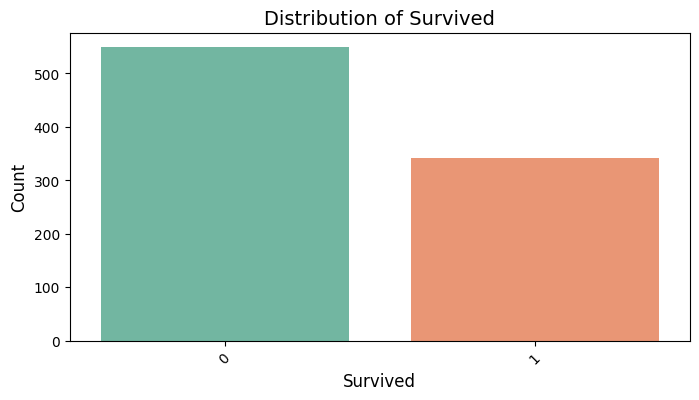

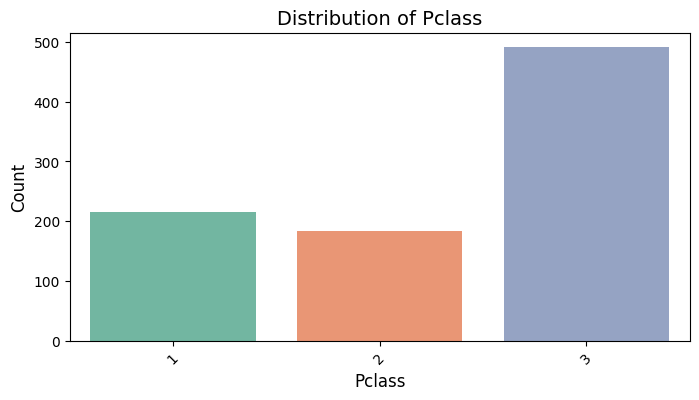

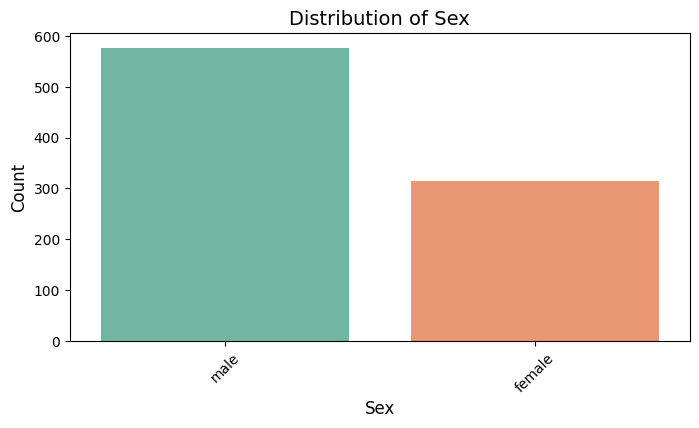

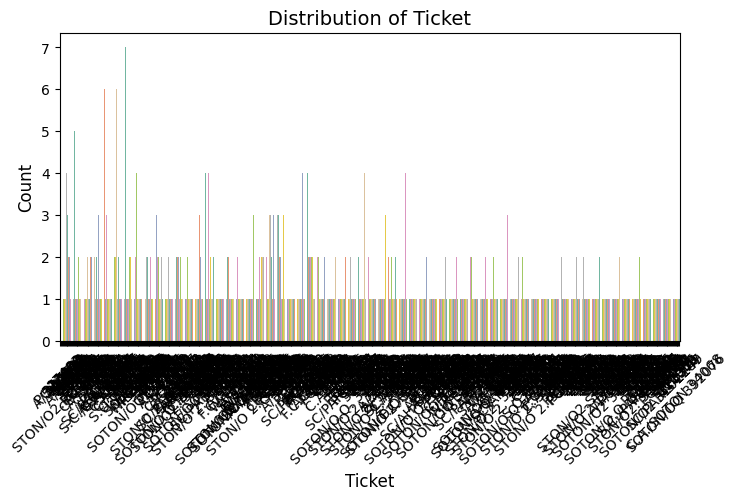

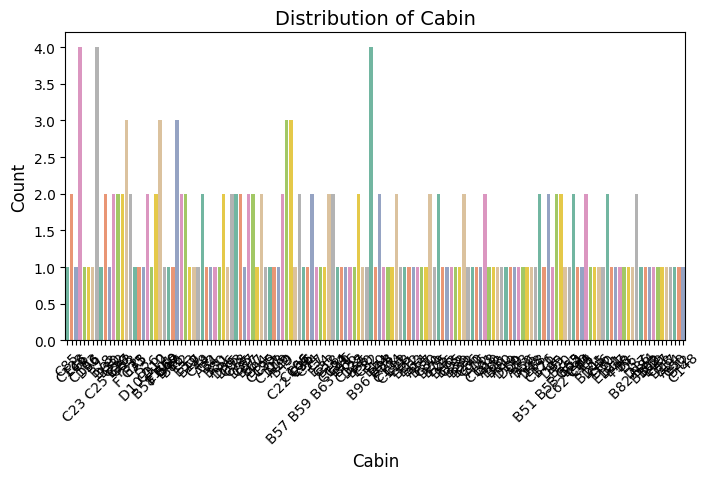

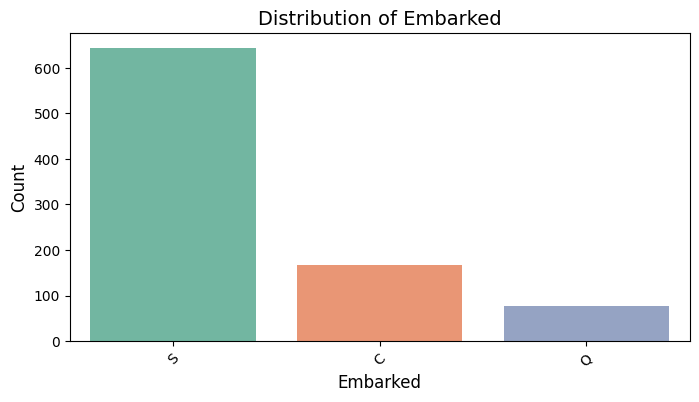

In [6]:
# Summary statistics for categorical features
categorical_features = training.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T

# Use the previously defined function to create a styled, scrollable table
html_categorical = create_scrollable_table(cat_summary_stats, 'categorical_features', 'Summary Statistics for Categorical Features')

# Enhanced display with HTML formatting
display(HTML(html_categorical))

# Plot histograms for specific categorical features
selected_categorical  =  training[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]
for i, column in enumerate(selected_categorical.columns, 1):
    plt.figure(figsize=(8, 4))  # Set the size of each individual plot
    sns.countplot(x=column, hue=column, data=selected_categorical, palette='Set2', legend=False)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)  # Rotate the x labels for better readability
    plt.show()  # Display each plot individually




In [ ]:
# Comparing survival with each of these categorical variables

# Survival vs Passenger Class (Pclass)
pclass_pivot = pd.pivot_table(training, index='Survived', columns='Pclass', values='Ticket', aggfunc='count')
print("Survival vs Passenger Class (Pclass):\n", pclass_pivot, "\n")

# Survival vs Sex
sex_pivot = pd.pivot_table(training, index='Survived', columns='Sex', values='Ticket', aggfunc='count')
print("Survival vs Sex:\n", sex_pivot, "\n")

# Survival vs Embarked
embarked_pivot = pd.pivot_table(training, index='Survived', columns='Embarked', values='Ticket', aggfunc='count')
print("Survival vs Embarked:\n", embarked_pivot)

In [ ]:
# Null values in the dataset
null_values = training.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), 'null_values', 'Null Values in the Dataset')

# Percentage of missing values for each feature
missing_percentage = (training.isnull().sum() / len(training)) * 100
html_missing_percentage = create_scrollable_table(missing_percentage.to_frame(), 'missing_percentage', 'Percentage of Missing Values for Each Feature')

# Exploring rows with missing values
rows_with_missing_values = training[training.isnull().any(axis=1)]
html_rows_with_missing_values = create_scrollable_table(rows_with_missing_values.head(), 'rows_with_missing_values', 'Rows with Missing Values')

# Display both tables together with enhanced HTML formatting
display(HTML(html_null_values + html_missing_percentage + html_rows_with_missing_values))

# What question do we want to ask of the data? 


1. Does Cabin Nature Impacts Survival Rate?  Investigate the trends  between the number of people in a cabin, the letter of the cabin and the survival rate. Investigate if we can use the cabin grouped by first letters as a categoricals variables. 

2. Does Ticket Nature Impacts Survival Rate? Invvestigate if there is relationship between the tickets number characters nature and the survival rate.

3.  Is there a correlation between any numerical variables? the effects of dependable variables that i too correlated in data science 

In [7]:
# 1. Understanding the nature of cabins 

# Creating a new feature 'cabin_multiple'
# This feature counts the number of cabins listed for each passenger (if any)
training['cabin_multiple'] = training.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# Analyze the distribution of cabin counts
# This helps in understanding how many passengers have multiple cabin assignments
cabin_count_distribution = training['cabin_multiple'].value_counts()

# Display the distribution of cabin counts
print("Distribution of Cabin Counts:")
print(cabin_count_distribution)

# Create a pivot table to analyze the relationship between survival and the number of cabins
# The table shows the count of tickets (or passengers) for each combination of survival status and cabin count

pivot_table = pd.pivot_table(
    training, 
    index='Survived',          # Rows will represent survival status
    columns='cabin_multiple',  # Columns will represent the count of cabins
    values='Ticket',           # Values in the table are counts of tickets
    aggfunc='count'            # Aggregation function to count tickets
)

# Display the pivot table
print(pivot_table)

# Create a new feature 'cabin_adv' based on the first letter of the cabin
# This process also treats null (NaN) values in 'Cabin' as a separate category
training['cabin_adv'] = training.Cabin.apply(lambda x: str(x)[0])

# Display the count of each category in the new 'cabin_adv' feature
print("Cabin Advanced Feature Counts:")
print(training['cabin_adv'].value_counts())

# Create a pivot table to compare survival rate by cabin category
# The table shows the count of names (or passengers) for each combination of survival status and cabin category
cabin_survival_pivot = pd.pivot_table(
    training,
    index='Survived',
    columns='cabin_adv',
    values='Name',
    aggfunc='count'
)

# Display the pivot table
print("\nSurvival Rate by Cabin Category:")
print(cabin_survival_pivot)

Distribution of Cabin Counts:
cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64
cabin_multiple      0      1    2    3    4
Survived                                   
0               481.0   58.0  7.0  3.0  NaN
1               206.0  122.0  9.0  3.0  2.0
Cabin Advanced Feature Counts:
cabin_adv
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

Survival Rate by Cabin Category:
cabin_adv    A     B     C     D     E    F    G    T      n
Survived                                                    
0          8.0  12.0  24.0   8.0   8.0  5.0  2.0  1.0  481.0
1          7.0  35.0  35.0  25.0  24.0  8.0  2.0  NaN  206.0


In [ ]:
# 2. Understanding Ticket values

# Categorize tickets as numeric or non-numeric
training['numeric_ticket'] = training.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
training['ticket_letters'] = training.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

# Analyze the distribution of numeric vs non-numeric tickets
print("Numeric Ticket Distribution:")
print(training['numeric_ticket'].value_counts())

# Analyze the distribution of ticket letter categories
print("\nTicket Letter Category Distribution:")
print(training['ticket_letters'].value_counts())

# Set pandas option to display all rows
pd.set_option("display.max_rows", None)

# Analyze survival rate by numeric vs non-numeric ticket type
print("\nSurvival Rate by Numeric vs Non-Numeric Ticket Type:")
numeric_ticket_pivot = pd.pivot_table(training, index='Survived', columns='numeric_ticket', values='Ticket', aggfunc='count')
print(numeric_ticket_pivot)

# Analyze survival rate across different ticket types (letters)
print("\nSurvival Rate by Ticket Letter Categories:")
ticket_letters_pivot = pd.pivot_table(training, index='Survived', columns='ticket_letters', values='Ticket', aggfunc='count')
print(ticket_letters_pivot)



In [ ]:
# 3. Analyze the correlation between numerical variables 

# Print the correlation matrix
corr_matrix = selected_numericals.corr()
print(corr_matrix)

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the heatmap
sns.heatmap(
    corr_matrix, 
    annot=True,       # Annotate cells with correlation values
    cmap='coolwarm',  # Color map for different correlation values
    fmt='.2f',        # Format of the annotations
    linewidths=.5,    # Space between cells
    cbar_kws={"shrink": .8}  # Adjust the color bar size
)
plt.title('Correlation Heatmap of Selected Numerical Features')
plt.show()

# Data Preprocessing Steps for Modeling
---
**1. Handling Missing Values:**
   - Remove the very few (only 2) missing values in the 'Embarked' column.

**2. Feature Selection:**
   - Focus on relevant variables for model efficiency, particularly due to limited data. Unnecessary features like 'Name' and 'Passenger ID' are excluded. The selected features are 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title'.

**3. Categorical Data Transformation:**
   - Perform categorical transformations on all data. Typically, a transformer would be used, but manual transformation ensures consistent columns in both training and test sets. This method might also offer insights into the test data's structure. Note: For typical applications outside competitions, using a one-hot encoder is generally advised.

**4. Imputation of Missing Data:**
   - Impute missing 'Fare' and 'Age' data using the mean value. Experimentation with the median value is also a consideration.

**5. Normalization of 'Fare':**
   - Apply a logarithmic transformation to the 'Fare' feature to achieve a more normal-like distribution.

**6. Scaling Features:**
   - Scale the data between 0 and 1 using a standard scaler for uniformity across all features. 

These preprocessing steps are crucial for preparing the dataset, ensuring that it's clean, relevant, and formatted correctly for effective modeling.

In [ ]:
# Feature Engineering
# -------------------

# Adding a feature to count the number of cabins listed
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# Extracting the first letter from the Cabin as a feature
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])

# Determining if a ticket is numeric or not
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)

# Extracting letters from the Ticket as a feature
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.', '').replace('/', '').lower() if len(x.split(' ')[:-1]) > 0 else 0)

# Extracting titles from the Name as a feature
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Data Imputation
# ---------------

# Filling missing Age values with the median of the Age in the training set
all_data.Age = all_data.Age.fillna(training.Age.median())

# Filling missing Fare values with the median of the Fare in the training set
all_data.Fare = all_data.Fare.fillna(training.Fare.median())

# Dropping rows where 'Embarked' is missing
all_data.dropna(subset=['Embarked'], inplace=True)

# Data Normalization
# ------------------

# Applying log normalization to SibSp
all_data['norm_sibsp'] = np.log(all_data.SibSp + 1)
all_data['norm_sibsp'].hist()
plt.title('Normalized SibSp')
plt.show()

# Applying log normalization to Fare
all_data['norm_fare'] = np.log(all_data.Fare + 1)
all_data['norm_fare'].hist()
plt.title('Normalized Fare')
plt.show()

# Converting 'Pclass' to a categorical feature for one-hot encoding
all_data.Pclass = all_data.Pclass.astype(str)

# Creating Dummy Variables
# ------------------------

# One-hot encoding of categorical features
all_dummies = pd.get_dummies(all_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'norm_fare', 'Embarked', 'cabin_adv', 'cabin_multiple', 'numeric_ticket', 'name_title', 'train_test']])

# Splitting the Data
# ------------------

# Separating the training and test sets
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis=1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis=1)

# Extracting the target variable 'Survived' for the training set
y_train = all_data[all_data.train_test == 1].Survived
print("Shape of y_train:", y_train.shape)

In [ ]:
# Scale Data
# ----------

# Initialize the StandardScaler
scale = StandardScaler()

# Create a copy of all_dummies to apply scaling
all_dummies_scaled = all_dummies.copy()

# Scale specific features: 'Age', 'SibSp', 'Parch', 'norm_fare'
features_to_scale = ['Age', 'SibSp', 'Parch', 'norm_fare']
all_dummies_scaled[features_to_scale] = scale.fit_transform(all_dummies_scaled[features_to_scale])

# Splitting the Scaled Data
# -------------------------

# Separating the training and test sets from the scaled data
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis=1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis=1)

# Extracting the Target Variable
# ------------------------------

# Extracting the target variable 'Survived' for the training set
y_train = all_data[all_data.train_test == 1].Survived

# Model Building: Establishing Baseline Performance

To set a foundation for further analysis, it's important to assess the baseline performance of various models using their default settings. I utilized 5-fold cross-validation to gauge their initial effectiveness. This baseline serves as a benchmark to understand the impact of subsequent tuning on each model. However, it's crucial to note that high baseline performance on the validation set doesn't necessarily guarantee superior results on the final test set. This initial evaluation helps in identifying models with the most potential for improvements and tuning.

In [ ]:
# Training and Evaluating Models
# ------------------------------


#  Baseline Model with Naive Bayes


# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Perform cross-validation
cv = cross_val_score(gnb, X_train_scaled, y_train, cv=5)

# Output the cross-validation results
print("Cross-validation scores:", cv)
print("Mean cross-validation score:", cv.mean())

# Logistic Regression
lr = LogisticRegression(max_iter=2000)
print("Logistic Regression - Cross-Validation Scores:")
cv_lr = cross_val_score(lr, X_train, y_train, cv=5)
print(cv_lr)
print("Average:", cv_lr.mean())

print("\nLogistic Regression with Scaled Data:")
cv_lr_scaled = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print(cv_lr_scaled)
print("Average:", cv_lr_scaled.mean())

# Decision Tree Classifier
dt = tree.DecisionTreeClassifier(random_state=1)
print("\nDecision Tree Classifier - Cross-Validation Scores:")
cv_dt = cross_val_score(dt, X_train, y_train, cv=5)
print(cv_dt)
print("Average:", cv_dt.mean())

print("\nDecision Tree with Scaled Data:")
cv_dt_scaled = cross_val_score(dt, X_train_scaled, y_train, cv=5)
print(cv_dt_scaled)
print("Average:", cv_dt_scaled.mean())

# K-Neighbors Classifier
knn = KNeighborsClassifier()
print("\nK-Neighbors Classifier - Cross-Validation Scores:")
cv_knn = cross_val_score(knn, X_train, y_train, cv=5)
print(cv_knn)
print("Average:", cv_knn.mean())

print("\nK-Neighbors with Scaled Data:")
cv_knn_scaled = cross_val_score(knn, X_train_scaled, y_train, cv=5)
print(cv_knn_scaled)
print("Average:", cv_knn_scaled.mean())

# Random Forest Classifier
rf = RandomForestClassifier(random_state=1)
print("\nRandom Forest Classifier - Cross-Validation Scores:")
cv_rf = cross_val_score(rf, X_train, y_train, cv=5)
print(cv_rf)
print("Average:", cv_rf.mean())

print("\nRandom Forest with Scaled Data:")
cv_rf_scaled = cross_val_score(rf, X_train_scaled, y_train, cv=5)
print(cv_rf_scaled)
print("Average:", cv_rf_scaled.mean())

# Support Vector Classifier
svc = SVC(probability=True)
print("\nSupport Vector Classifier with Scaled Data:")
cv_svc_scaled = cross_val_score(svc, X_train_scaled, y_train, cv=5)
print(cv_svc_scaled)
print("Average:", cv_svc_scaled.mean())

# XGBoost Classifier
xgb = XGBClassifier(random_state=1)
print("\nXGBoost Classifier with Scaled Data:")
cv_xgb_scaled = cross_val_score(xgb, X_train_scaled, y_train, cv=5)
print(cv_xgb_scaled)
print("Average:", cv_xgb_scaled.mean())

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('knn', knn), ('rf', rf), ('svc', svc), ('xgb', xgb)],
    voting='soft'
)
print("\nVoting Classifier with Scaled Data:")
cv_voting = cross_val_score(voting_clf, X_train_scaled, y_train, cv=5)
print(cv_voting)
print("Average:", cv_voting.mean())

# Training the Voting Classifier and Making Predictions
voting_clf.fit(X_train_scaled, y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)

# Creating Submission File
basic_submission = {'PassengerId': test.PassengerId, 'Survived': y_hat_base_vc}
base_submission = pd.DataFrame(basic_submission)
base_submission.to_csv('base_submission.csv', index=False)

print("\nSubmission file created: 'base_submission.csv'")